# Product Category Classification

In [1]:
import sys
sys.path.append('../eda')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import itertools
from utils import *

### Prepare data

We will use categories that have at lease 100 products with ingredient info. As one product may belong to more than one category, we will do a multi-label classification.

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# drop products without ingredient info
df = df.loc[~df['ingredient'].isnull()]

# pick large categories, with more than 100 products
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum','Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer',
                    'Sunscreen', 'Toner & Face Mist', 'Face Mask',
                    'Acne & Blemish Treatment', 'Scrub', 'Lip Balm',
                    'Body Lotion', 'Foundation', 'Lip Stick/Gloss/Liner', 
                    'Foundation Primer', 'Face Powder']
df = df.loc[df['product_category'].isin(large_categories)]

# merge same product rows and combine categories into set
product_category_set = df.groupby(['product_names','brand'])['product_category'].apply(set)
df = df.groupby(['product_names','brand']).first()
df['product_category'] = product_category_set
df = df.reset_index()
df.head()

,product_names,brand,product_category,ingredient,size,price,size_num,size_unit,avg_price,active_ingredient,...,active_cat_count_Texture Enhancer,active_cat_count_Thickeners/Emulsifiers,active_cat_count_Uncategorized,active_cat_count_Vitamins,active_mean_rating,inactive_mean_rating,inactive_mean_rating_w1,inactive_mean_rating_w2,active_cat_count_Absorbent,active_cat_count_Emulsifiers
0,1% Retinol Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Glycereth-7 Triacetate (emollien...",0.50 fl. oz.,52.0,15.0,ml,3.466667,NaN,...,0.0,0.0,0.0,0.0,NaN,2.172414,2.170828,2.145176,NaN,NaN
1,10 HR Wear Perfection Foundation,Sephora,{Foundation},"Water, Dimethicone, CI77891 (Titanium Dioxide)...",NaN,20.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,NaN,2.034483,2.062283,2.046158,0.0,0.0
2,10% Glycolic Solutions Moisturizer,Peter Thomas Roth,{Exfoliants},"Water, Water/Aqua/Eau, Glycolic Acid, Glycerin...",2.20 fl. oz.,45.0,65.0,ml,0.692308,NaN,...,0.0,0.0,0.0,0.0,NaN,2.310345,2.267128,2.320281,NaN,NaN
3,10% Niacinamide Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Niacinamide (vitamin B3, skin-re...",0.67 fl. oz.,42.0,20.0,ml,2.100000,NaN,...,0.0,0.0,0.0,0.0,NaN,2.500000,2.506232,2.615566,NaN,NaN
4,100% Mineral Sunscreen Mist SPF 30,Supergoop!,{Sunscreen},Active: Zinc Oxide (12%). Other: Aloe Barbaden...,6.00 fl. oz.,34.0,177.0,ml,0.192090,Zinc Oxide (12%).,...,0.0,1.0,0.0,0.0,3.0,2.210526,2.210526,2.210526,NaN,NaN


### Count ingredients

We will count the matched ingredient. The feature matrix will be N_product * N_ingredients, with 0 or 1 indicate whether certain ingredient exists in a product. These binary-valued features are suitable for Bernoulli Naive Bayes classification.

In [3]:
ingredient_count_df = get_matching_ingredient_count(df)
ingredient_count_df.head()

,octyldodecanol,alpha hydroxy acid,glycosphingolipid,tetrahydrodemethoxycurcumin,SD alcohol 40-2,Pogostemon cablin,Filipendula glaberrima,beta-sitosterol,Cola acuminata seed extract,magnesium sulfate,...,Pistacia vera seed oil,algin,acacia senegal gum,formaldehyde-releasing preservative,Limnanthes alba,d-alpha-tocopherol,cetyl acetate,eucalyptus extract,Bambusa vulgaris (bamboo) leaf,serine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Training

* Label product categories
* Split train and test set
* Use Bernoulli naive bayes as estimator
* Do one vs rest multi-label classification

In [4]:
X = ingredient_count_df
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['product_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=777)

NB = BernoulliNB()
model = OneVsRestClassifier(NB)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Define some metric for multi-label classification
* multilable confusion matrix
* hamming score

In [5]:
def multilable_confusion_matrix(y_true, y_pred, classes=None):
# confusion matrix for multilabel classification
# diagonal counts true positives
# off-diagonal counts false positives
    if (y_true.shape != y_pred.shape):
        raise ValueError("y_true and y_pred shape do not match in multilable_confusion_matrix")
        
    n_samples, n_class = y_true.shape
    m_confusion_matrix = np.zeros([n_class, n_class])
    
    for n in range(n_samples):
        set_true = set(np.where(y_true[n])[0])
        set_pred = set(np.where(y_pred[n])[0])
        
        tp = set_true.intersection(set_pred) 
        fp = set_pred.difference(set_true)
        #fn = set_true.difference(set_pred)
        
        for i in tp:
           m_confusion_matrix[i,i] += 1
        for i in set_true:
            for j in fp:
                m_confusion_matrix[i,j] += 1
                
    confusion_matrix_df = pd.DataFrame(m_confusion_matrix.astype('int'), index=classes, columns=classes)
    confusion_matrix_df.index.name = "true class"
    confusion_matrix_df.columns.name = "predicted class"
    return confusion_matrix_df

def hamming_score(y_true, y_pred, score_by_sample=False):
# intersection over union score for multilabel classification
    if (y_true.shape != y_pred.shape):
        raise ValueError("y_true and y_pred shape do not match in hamming_score")
        
    n_samples, n_class = y_true.shape
    acc_list = []
    for n in range(n_samples):
        set_true = set(np.where(y_true[n])[0])
        set_pred = set(np.where(y_pred[n])[0])
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)))
        acc_list.append(tmp_a)
        
    if score_by_sample:
        return np.mean(acc_list), acc_list
    else:
        return np.mean(acc_list)

# simple test
y_true = np.array([[0,1,0,1],
                   [0,1,1,0],
                   [1,0,1,0],
                   [0,0,1,1]])

y_pred = np.array([[0,1,1,0],
                   [0,1,1,0],
                   [0,1,1,1],
                   [0,0,0,1]])

mean_hamming, hamming_list = hamming_score(y_true, y_pred, score_by_sample=True)
print("hamming score:", mean_hamming, hamming_list)
multilable_confusion_matrix(y_true, y_pred)

hamming score: 0.5208333333333333 [0.3333333333333333, 1.0, 0.25, 0.5]


predicted class,0,1,2,3
true class,,,,
0,0,1,0,1
1,0,2,1,0
2,0,1,2,1
3,0,0,1,1


### Evaluate predictions

In [6]:
train_score = hamming_score(y_train, y_train_pred)
test_score = hamming_score(y_test, y_test_pred)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

train_confmat = multilable_confusion_matrix(y_train, y_train_pred, mlb.classes_)
test_confmat = multilable_confusion_matrix(y_test, y_test_pred, mlb.classes_)

Hamming score: (train)0.4410, (test)0.3825


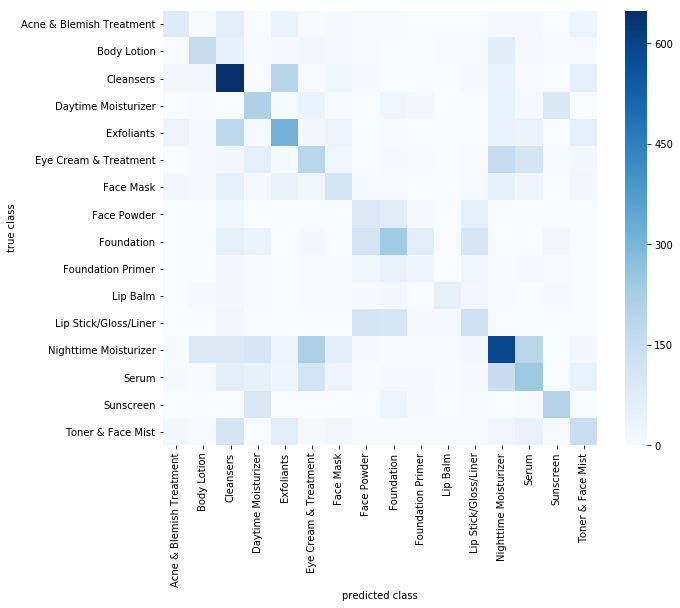

In [7]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(train_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

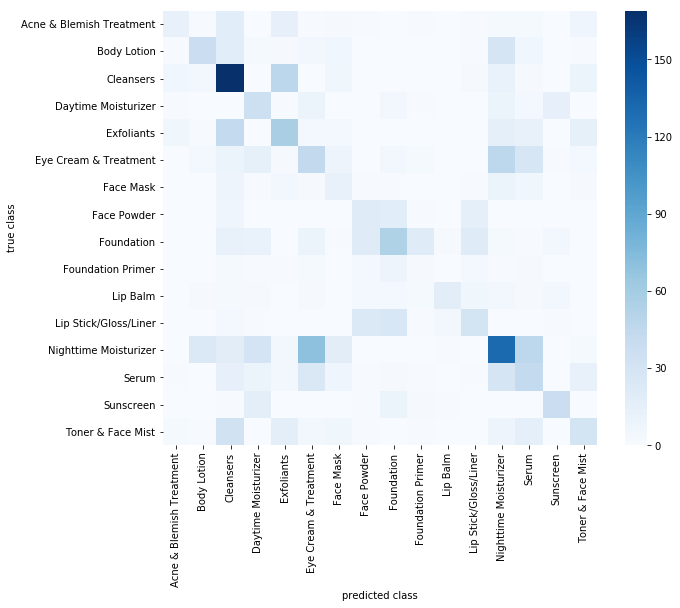

In [8]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(test_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

### More analysis for each category
* Accuracy
* Most Common miss-predictions
* Most predictive ingredients for each category

In [9]:
for i, (idx, row) in enumerate(test_confmat.iterrows()):
    accuracy = row[idx] / y_test[:,i].sum()
    print ("true class:", idx)
    print ("accuracy: %.3f"%accuracy)
    confused_class = row.sort_values(ascending=False).drop(idx).iloc[:3].index.values
    print ("top miss predictions:", confused_class, '\n')

true class: Acne & Blemish Treatment
accuracy: 0.333
top miss predictions: ['Cleansers' 'Exfoliants' 'Toner & Face Mist'] 

true class: Body Lotion
accuracy: 0.613
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Cleansers
accuracy: 0.899
top miss predictions: ['Exfoliants' 'Nighttime Moisturizer' 'Toner & Face Mist'] 

true class: Daytime Moisturizer
accuracy: 0.692
top miss predictions: ['Sunscreen' 'Nighttime Moisturizer' 'Eye Cream & Treatment'] 

true class: Exfoliants
accuracy: 0.576
top miss predictions: ['Cleansers' 'Nighttime Moisturizer' 'Toner & Face Mist'] 

true class: Eye Cream & Treatment
accuracy: 0.454
top miss predictions: ['Nighttime Moisturizer' 'Serum' 'Daytime Moisturizer'] 

true class: Face Mask
accuracy: 0.361
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Face Powder
accuracy: 0.870
top miss predictions: ['Foundation' 'Lip Stick/Gloss/Liner' 'Cleansers'] 

true class: Foundation
accuracy: 0.90

Make a prediction for each individual ingredient, for each category, find the top 10 ingredients that give highest probability.

In [10]:
n_ingredients = ingredient_count_df.shape[1]
X_ingredients = np.eye(n_ingredients,n_ingredients)
y_ingredients = model.predict_proba(X_ingredients)

most_relevant_ingredients = pd.DataFrame()
for i in range(len(mlb.classes_)):
    ind = np.argsort(y_ingredients[:,i])
    top10 = np.flipud(ingredient_count_df.columns.values[ind[-10:]])
    most_relevant_ingredients[mlb.classes_[i]] = top10
    
most_relevant_ingredients

,Acne & Blemish Treatment,Body Lotion,Cleansers,Daytime Moisturizer,Exfoliants,Eye Cream & Treatment,Face Mask,Face Powder,Foundation,Foundation Primer,Lip Balm,Lip Stick/Gloss/Liner,Nighttime Moisturizer,Serum,Sunscreen,Toner & Face Mist
0,advanced glycation endproduct (AGE),Larrea tridentata,sodium palm kernelate,vitamin B3,alpha hydroxy acid,hesperidin methyl chalcone,glycerol triacetate,isocetyl salicylate,titanium dioxide,vitamin B1,flavor,red 27 lake,anthocyanin,Uva ursi extract,octocrylene,mallow
1,benzoyl peroxide,erythrulose,sodium palmate,avobenzone,pectin,hesperidin,saccharomyces selenium ferment,thymus hydrolysate,iron oxides,borate,aroma,yellow 6 lake,spearmint oil,styrene,phthalates,pellitory
2,Xi xin,ylang ylang,sodium tallowate,padimate O,azelaic acid,Pseudopterogorgia elisabethae,bois oil,glyceryl ester,simethicone,gotu kola,capsaicin,red 6 lake,docosahexaenoic acid,tetrahydromethoxycurcumin,film-forming agent,lye
3,fatty acid,neroli,tetrasodium etidronate,meradmiate,trimellitic anhydride copolymer,oxidoreductase,rose hip,fish cartilage extract,environmental damage,Arctium majus,lemon juice,blue 1 lake,lipid,beta hydroxy acid,homosalate,coneflower
4,sulfur,black locust extract,lauric acid,ecamsule,BHA (beta hydroxy acid),tripeptide-32,Sambucus nigra,Astragalus sinicus,Prunus americana,D&C,marshmallow,terephthalylidene dicamphor sulfonic acid,Helianthus oil,durian,oxybenzone,nonoxynols
5,myristoyl tripeptide-31,stearalkonium chloride,potassium myristate,galbanum,walnut shell powder,N-acetyl-L tyrosine,Mentha viridis,GLA,astaxanthin extract,GLA,candelilla wax,jojoba,d-alpha-tocopherol,glyceryl ascorbate,avobenzone,PPG-20
6,bakuchiol,Buxus chinensis,cocamidopropyl betaine,film-forming agent,mandelic acid,polyhydroxy acid,silt,English ivy extract,acetyl glyceryl ricinoleate,glyceryl ester,Ricinus communis,carmine,olive oil,bay leaf oil,diethylhexyl malate,burdock root
7,BHA (beta hydroxy acid),troxerutin,sodium cocoamphoacetate,eicosapentaenoic acid,fatty acid,slip agent,kaolin,reducing agent,isopropyl titanium triisostearte,fish cartilage extract,Illicium vernum,fir needle oil,olive fruit oil,fireweed extract,octisalate,lemon
8,sebacic acid,anisaldehyde,sodium laureth sulfate,jojoba butter,Citrus amara,verbena extract,bentonite,juniper berry,methicone,Astragalus sinicus,candelilla,China clay,gums,fuller's earth,eicosene copolymer,soapwort
9,colloidal silver,hydroxyethyl acrylate,sodium cocoyl isethionate,egg yolk,mugwort extract,vitamin D,montmorillonite,acetylated castor oil,disteardimonium hectorite,acetylated castor oil,capsicum oleoresin,gluten ingredients,poloxamers,lauramphocarboxyglycinate,citrate buffer,para-aminobenzoic acid (PABA)
